### Testing Raw Cible WB

## Part 1: Setup and Data Loading


In [1]:
### Dowload and install dependencies for the project
# %matplotlib inline
%pip install setuptools wheel cython statsmodels
%pip install kaleido jinja2


[notice] A new release of pip available: 22.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)

[notice] A new release of pip available: 22.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
### ====================
### Importing libraries
### ====================
%load_ext autoreload
%autoreload 2
import sys
import openpyxl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#import shap
import os
import warnings

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
### ====================
### Set up visualization and warnings
### ====================
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)
# sns.set_palette('viridis')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2025-06-05 17:40:56.125403: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-05 17:40:56.550776: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-06-05 17:40:56.550878: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-06-05 17:40:56.607351: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-05 17:40:58.509639: W tensorflow/stream_executor/platform/de

In [3]:
### ====================
### File paths
###  ===================
# Create directories for model saving
models_dir = '../../models'
for model_type in ['simple_models', 'ml_models', 'dl_models']:
    models_dir = os.path.join(models_dir, model_type)
    os.makedirs(models_dir, exist_ok=True)

# Load Excel file
maquettes_path = "../../data/raw/"
maquettes= ["RawData-Cibles.xlsx"]
for maquette in maquettes:
    maquettes_path = os.path.join(maquettes_path, maquette)
sheets = ["Mur", "Sols", "Poutre", "Poteaux"]  # Adjusted based on your description


## Import Pythoon Modules
sys.path.append("../../module_python")

### Export Plots
plots_folder = "../../plot"
#os.makedirs(export_folder, exist_ok=True)


In [4]:
import excel_data_loader
data = excel_data_loader.load_data(maquettes_path)


# Access the DataFrames
murs_df = data.get('Murs')
sols_df = data.get('Sols')
poutres_df = data.get('Poutres')
poteaux_df = data.get('Poteaux')

# Display basic info
print("Murs DataFrame Shape:", murs_df.shape)
print("Sols DataFrame Shape:", sols_df.shape)
print("Poutres DataFrame Shape:", poutres_df.shape)
print("Poteaux DataFrame Shape:", poteaux_df.shape)

# Display column names
for sheet_name, df in data.items():
    print(f"\n{sheet_name} DataFrame Preview:")
    print(df.columns)

Data loaded successfully from the Excel file.
Murs DataFrame Shape: (312, 96)
Sols DataFrame Shape: (107, 94)
Poutres DataFrame Shape: (246, 100)
Poteaux DataFrame Shape: (68, 87)

Murs DataFrame Preview:
Index(['Id', '011EC_Lot', '012EC_Ouvrage', '013EC_Localisation',
       '014EC_Mode Constructif', 'Nom', 'Hauteur', 'Epaisseur', 'AI', 'AS',
       'Sols en intersection', 'Sols coupés (u)', 'Sols coupés (Ids)',
       'Sols coupants (u)', 'Sols coupants (Ids)', 'Sol au-dessus',
       'Sol en-dessous', 'Fenêtres', 'Portes', 'Ouvertures', 'Murs imbriqués',
       'Mur multicouche', 'Mur empilé', 'Profil modifié', 'Image', 'Catégorie',
       'Section', 'Type prédéfini d'IFC', 'Exporter au format IFC sous',
       'Exporter au format IFC', 'IfcGUID', 'A une association',
       'Enrobage d'armature - Autres faces',
       'Enrobage d'armature - Face intérieure',
       'Enrobage d'armature - Face extérieure', 'Variantes',
       'Extension inférieure', 'Extension supérieure', 'Volume',

## Part 2: Data Preprocessing and Relationship Mapping


📂 Loading and sanitizing Excel file...
✅ Murs: Sanitized 31 columns
✅ Sols: Sanitized 23 columns
✅ Poutres: Sanitized 23 columns
✅ Poteaux: Sanitized 26 columns
🔍 COLUMN MAPPING ANALYSIS

📊 DataFrame Column Counts:
   Murs: 31 columns
   Sols: 23 columns
   Poutres: 23 columns
   Poteaux: 26 columns

🌐 Total Unique Columns Across All DataFrames: 103

🤝 Common Columns (found in multiple DataFrames): 0

🔗 Relationship Columns (coupés/coupants mappings): 15
   'Poutre_Sols_coupants_Ids' in Poutres → references 'Sol_Id' in Sols
   'Poteau_Sols_coupés_Ids' in Poteaux → references 'Sol_Id' in Sols
   'Poutre_Sols_coupés_Ids' in Poutres → references 'Sol_Id' in Sols
   'Mur_Sols_coupants_Ids' in Murs → references 'Sol_Id' in Sols
   'Poteau_Poutres_coupés_Ids' in Poteaux → references 'Poutre_Id' in Poutres
   'Poteau_Poutres_coupants_Ids' in Poteaux → references 'Poutre_Id' in Poutres
   'Sol_Poutres_coupés_Ids' in Sols → references 'Poutre_Id' in Poutres
   'Poutre_Poteaux_coupés_Ids' in Pou

,Murs,Sols,Poutres,Poteaux


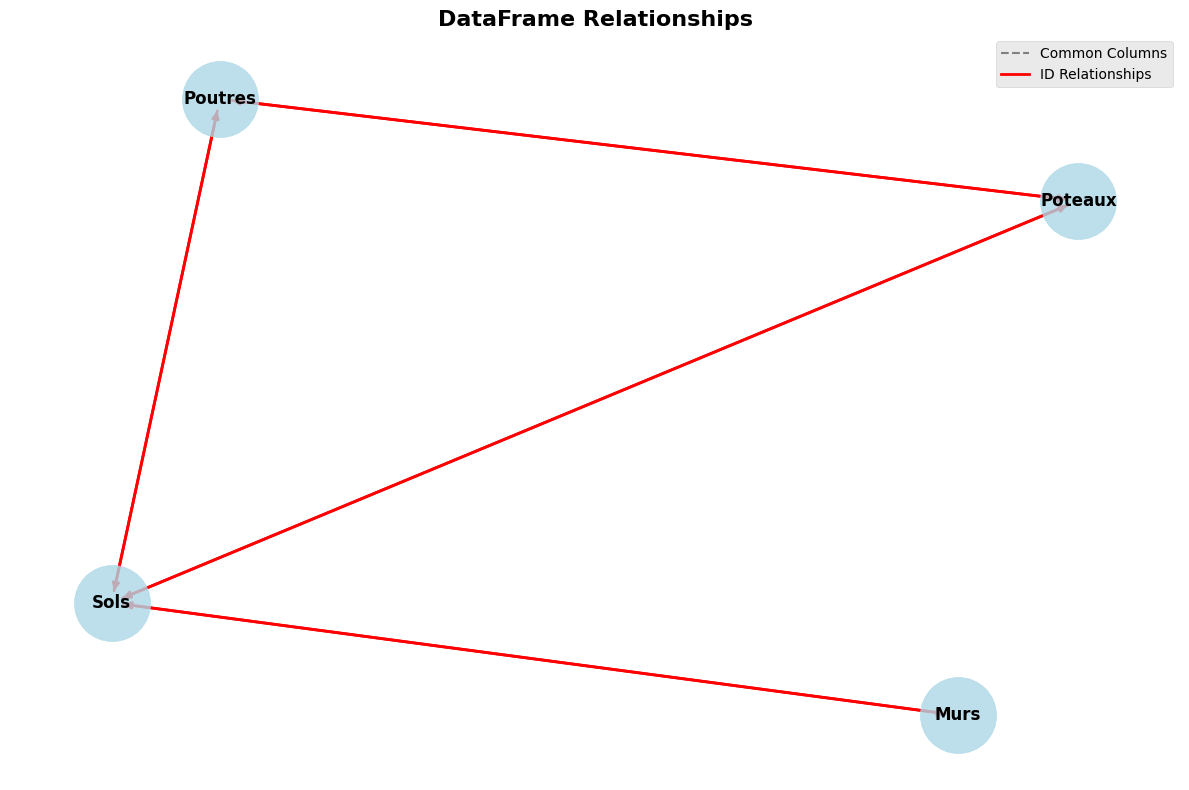

In [5]:
### ========================================
### Sanitization and Relationship Analysis
### ========================================
### Import the cleaner and mapper
from excel_essential_columns_cleaner import load_and_sanitize_data
from excel_map_sanitized_columns import analyze_relationships, display_column_mapping_results, generate_relationship_graph_matplotlib

# 1. Load and fully sanitize the data
sanitized_data = load_and_sanitize_data(maquettes_path)

### Now ALL subsequent operations use the sanitized data
### --------------------------------------------------

### 2. Analyze relationships
relationships = analyze_relationships(sanitized_data)

### 3. Display results
display_column_mapping_results(relationships, sanitized_data)


### Now work exclusively with sanitized_data for all operations
murs_df = sanitized_data['Murs']
sols_df = sanitized_data['Sols']
poutres_df = sanitized_data['Poutres']
poteaux_df = sanitized_data['Poteaux']

### 4. Generate graph
generate_relationship_graph_matplotlib(relationships)
### save the graph if not already saved
graph_path = os.path.join(plots_folder, "relationship_graph.png")
if not os.path.exists(graph_path):
    plt.savefig(graph_path, bbox_inches='tight')
    print(f"Graph saved to {graph_path}")

In [6]:
import excel_clean_ids_columns

df_dict = {'Murs': murs_df, 'Sols': sols_df, 'Poutres': poutres_df, 'Poteaux': poteaux_df}

cleaned_dfs, renamed_columns = excel_clean_ids_columns.clean_ids_columns(df_dict)

🛁 Starting ID columns cleaning...

📋 Murs:

 🔄 Processing: Mur_Sols_coupés_u ↔ Mur_Sols_coupés_Ids


,Before_u,After_u,Before_ids,After_ids
0,0,0,nan,0
1,0,0,nan,0
2,0,0,nan,0


 ✨ Renamed to: Mur_Sols_coupés_Ids_cleaned
──────────────────────────────────────────────────

 🔄 Processing: Mur_Sols_coupants_u ↔ Mur_Sols_coupants_Ids


,Before_u,After_u,Before_ids,After_ids
0,3,3,"1788267,1788458,1790282","1788267,1788458,1790282"
1,1,1,1788267,1788267
2,1,1,1788267,1788267


 ✨ Renamed to: Mur_Sols_coupants_Ids_cleaned
──────────────────────────────────────────────────
📋 Sols:

 🔄 Processing: Sol_Murs_coupés_u ↔ Sol_Murs_coupés_Ids


,Before_u,After_u,Before_ids,After_ids
0,0,0,nan,0
1,9,9,"1787858,1787860,1787874,1789104,1789106,179026...","1787858,1787860,1787874,1789104,1789106,179026..."
2,3,3,"1788054,1789308,1794860","1788054,1789308,1794860"


 ✨ Renamed to: Sol_Murs_coupés_Ids_cleaned
──────────────────────────────────────────────────

 🔄 Processing: Sol_Murs_coupants_u ↔ Sol_Murs_coupants_Ids


,Before_u,After_u,Before_ids,After_ids
0,0,0,nan,0
1,0,0,nan,0
2,0,0,nan,0


 ✨ Renamed to: Sol_Murs_coupants_Ids_cleaned
──────────────────────────────────────────────────

 🔄 Processing: Sol_Poutres_coupés_u ↔ Sol_Poutres_coupés_Ids


,Before_u,After_u,Before_ids,After_ids
0,1,1,1793428,1793428
1,1,1,1788274,1788274
2,0,0,nan,0


 ✨ Renamed to: Sol_Poutres_coupés_Ids_cleaned
──────────────────────────────────────────────────

 🔄 Processing: Sol_Poutres_coupants_u ↔ Sol_Poutres_coupants_Ids


,Before_u,After_u,Before_ids,After_ids
0,0,0,nan,0
1,0,0,nan,0
2,0,0,nan,0


 ✨ Renamed to: Sol_Poutres_coupants_Ids_cleaned
──────────────────────────────────────────────────

 🔄 Processing: Sol_Poteaux_coupés_u ↔ Sol_Poteaux_coupés_Ids


,Before_u,After_u,Before_ids,After_ids
0,0,0,nan,0
1,0,0,nan,0
2,0,0,nan,0


 ✨ Renamed to: Sol_Poteaux_coupés_Ids_cleaned
──────────────────────────────────────────────────

 🔄 Processing: Sol_Poteaux_coupants_u ↔ Sol_Poteaux_coupants_Ids


,Before_u,After_u,Before_ids,After_ids
0,0,0,nan,0
1,0,0,nan,0
2,0,0,nan,0


 ✨ Renamed to: Sol_Poteaux_coupants_Ids_cleaned
──────────────────────────────────────────────────
📋 Poutres:

 🔄 Processing: Poutre_Sols_coupés_u ↔ Poutre_Sols_coupés_Ids


,Before_u,After_u,Before_ids,After_ids
0,0,0,nan,0
1,0,0,nan,0
2,0,0,nan,0


 ✨ Renamed to: Poutre_Sols_coupés_Ids_cleaned
──────────────────────────────────────────────────

 🔄 Processing: Poutre_Sols_coupants_u ↔ Poutre_Sols_coupants_Ids


,Before_u,After_u,Before_ids,After_ids
0,0,0,nan,0
1,0,0,nan,0
2,0,0,nan,0


 ✨ Renamed to: Poutre_Sols_coupants_Ids_cleaned
──────────────────────────────────────────────────

 🔄 Processing: Poutre_Poteaux_coupés_u ↔ Poutre_Poteaux_coupés_Ids


,Before_u,After_u,Before_ids,After_ids
0,0,0,nan,0
1,0,0,nan,0
2,0,0,nan,0


 ✨ Renamed to: Poutre_Poteaux_coupés_Ids_cleaned
──────────────────────────────────────────────────
 ⚠️ Poutre_Poteaux_coupants_u → No matching IDs column
📋 Poteaux:

 🔄 Processing: Poteau_Sols_coupés_u ↔ Poteau_Sols_coupés_Ids


,Before_u,After_u,Before_ids,After_ids
0,0,0,nan,0
1,0,0,nan,0
2,0,0,nan,0


 ✨ Renamed to: Poteau_Sols_coupés_Ids_cleaned
──────────────────────────────────────────────────

 🔄 Processing: Poteau_Sols_coupants_u ↔ Poteau_Sols_coupants_Ids


,Before_u,After_u,Before_ids,After_ids
0,1,1,1788810,1788810
1,0,0,nan,0
2,0,0,nan,0


 ✨ Renamed to: Poteau_Sols_coupants_Ids_cleaned
──────────────────────────────────────────────────

 🔄 Processing: Poteau_Poutres_coupés_u ↔ Poteau_Poutres_coupés_Ids


,Before_u,After_u,Before_ids,After_ids
0,2,2,"1788966,1795639","1788966,1795639"
1,1,1,1788934,1788934
2,1,1,1788936,1788936


 ✨ Renamed to: Poteau_Poutres_coupés_Ids_cleaned
──────────────────────────────────────────────────

 🔄 Processing: Poteau_Poutres_coupants_u ↔ Poteau_Poutres_coupants_Ids


,Before_u,After_u,Before_ids,After_ids
0,0,0,nan,0
1,0,0,nan,0
2,0,0,nan,0


 ✨ Renamed to: Poteau_Poutres_coupants_Ids_cleaned
──────────────────────────────────────────────────

✅ FINAL COLUMNS PER DATAFRAME:

📌 Murs columns:
 • Mur_Id 
 • Mur_011EC_Lot 
 • Mur_012EC_Ouvrage 
 • Mur_013EC_Localisation 
 • Mur_014EC_Mode_Constructif 
 • Mur_Hauteur 
 • Mur_Epaisseur 
 • Mur_AI 
 • Mur_AS 
 • Mur_Sols_en_intersection 
 • Mur_Sols_coupés_u 
 • Mur_Sols_coupés_Ids_cleaned (renamed)
 • Mur_Sols_coupants_u 
 • Mur_Sols_coupants_Ids_cleaned (renamed)
 • Mur_Sol_au-dessus 
 • Mur_Sol_en-dessous 
 • Mur_Fenêtres 
 • Mur_Portes 
 • Mur_Ouvertures 
 • Mur_Murs_imbriqués 
 • Mur_Mur_multicouche 
 • Mur_Profil_modifié 
 • Mur_Extension_inférieure 
 • Mur_Extension_supérieure 
 • Mur_Volume 
 • Mur_Surface 
 • Mur_Partie_inférieure_attachée 
 • Mur_Partie_supérieure_attachée 
 • Mur_Décalage_supérieur 
 • Mur_Décalage_inférieur 
 • Mur_Matériau_structurel 

📌 Sols columns:
 • Sol_Id 
 • Sol_011EC_Lot 
 • Sol_012EC_Ouvrage 
 • Sol_013EC_Localisation 
 • Sol_014EC_Mode_Const


🔍 Processing Murs...
✅ Found & Processed: Mur_Sols_coupés_Ids_cleaned, Added Count Column: Mur_Sols_coupés_Ids_cleaned_count
✅ Found & Processed: Mur_Sols_coupants_Ids_cleaned, Added Count Column: Mur_Sols_coupants_Ids_cleaned_count

🔍 Processing Sols...
✅ Found & Processed: Sol_Murs_coupés_Ids_cleaned, Added Count Column: Sol_Murs_coupés_Ids_cleaned_count
✅ Found & Processed: Sol_Murs_coupants_Ids_cleaned, Added Count Column: Sol_Murs_coupants_Ids_cleaned_count
✅ Found & Processed: Sol_Poutres_coupés_Ids_cleaned, Added Count Column: Sol_Poutres_coupés_Ids_cleaned_count
✅ Found & Processed: Sol_Poutres_coupants_Ids_cleaned, Added Count Column: Sol_Poutres_coupants_Ids_cleaned_count
✅ Found & Processed: Sol_Poteaux_coupés_Ids_cleaned, Added Count Column: Sol_Poteaux_coupés_Ids_cleaned_count
✅ Found & Processed: Sol_Poteaux_coupants_Ids_cleaned, Added Count Column: Sol_Poteaux_coupants_Ids_cleaned_count

🔍 Processing Poutres...
✅ Found & Processed: Poutre_Sols_coupés_Ids_cleaned, Added 

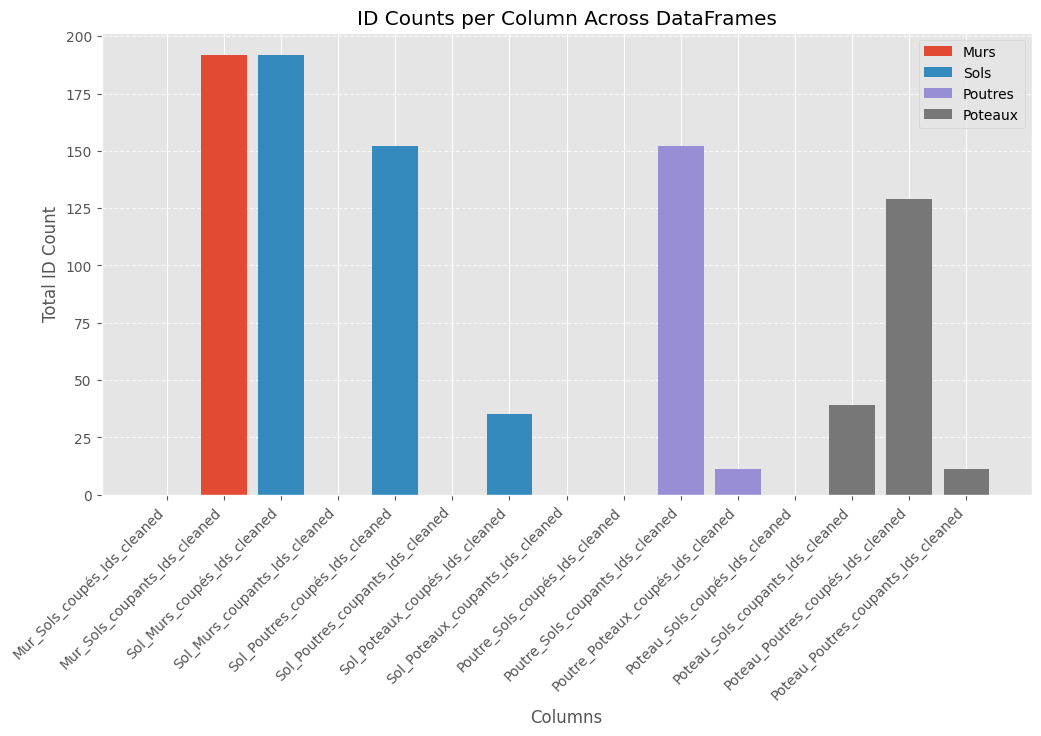

In [7]:
from excel_insertions_ids_counter import count_ids_per_row, plot_id_counts

df_dict, renamed_columns = count_ids_per_row(df_dict)
### ======================
### Show detected columns
### ======================
print("\n🆕 Processed Columns:")
for col_name in renamed_columns.keys():
    print(f"Detected & counted: {col_name}")

### ========================================
### Validate count columns in each DataFrame
### ========================================
for name, df in df_dict.items():
    df_count_cols = [col + "_count" for col in renamed_columns.keys() if (col + "_count") in df.columns]
    print(f"\n{name} DataFrame count columns:")
    if df_count_cols:
        print(df[df_count_cols].head())
    else:
        print("⚠️ No count columns found.")

### ========================================
### Generate plot based on processed data
### ========================================
plot_id_counts(df_dict, renamed_columns)
### save the graph if not already saved
graph_path = os.path.join(plots_folder, "id_counts.png")
if not os.path.exists(graph_path):
    plt.savefig(graph_path, bbox_inches='tight')
    print(f"Graph saved to {graph_path}")


🔍 Processing relationships for Murs...
🔗 Linking Mur_Sols_coupés_Ids_cleaned in Murs → Sols
✅ Successfully linked 28 features from Sols
🔗 Linking Mur_Sols_coupants_Ids_cleaned in Murs → Sols
❌ Failed to process Mur_Sols_coupants_Ids_cleaned: cannot reindex on an axis with duplicate labels
🔗 Linking Mur_Sols_coupés_Ids_cleaned_count in Murs → Sols
✅ Successfully linked 28 features from Sols
🔗 Linking Mur_Sols_coupants_Ids_cleaned_count in Murs → Sols
✅ Successfully linked 28 features from Sols

🔍 Processing relationships for Sols...
🔗 Linking Sol_Murs_coupés_Ids_cleaned in Sols → Murs
❌ Failed to process Sol_Murs_coupés_Ids_cleaned: cannot reindex on an axis with duplicate labels
🔗 Linking Sol_Murs_coupants_Ids_cleaned in Sols → Murs
✅ Successfully linked 60 features from Murs
🔗 Linking Sol_Poutres_coupés_Ids_cleaned in Sols → Poutres
❌ Failed to process Sol_Poutres_coupés_Ids_cleaned: cannot reindex on an axis with duplicate labels
🔗 Linking Sol_Poutres_coupants_Ids_cleaned in Sols → 

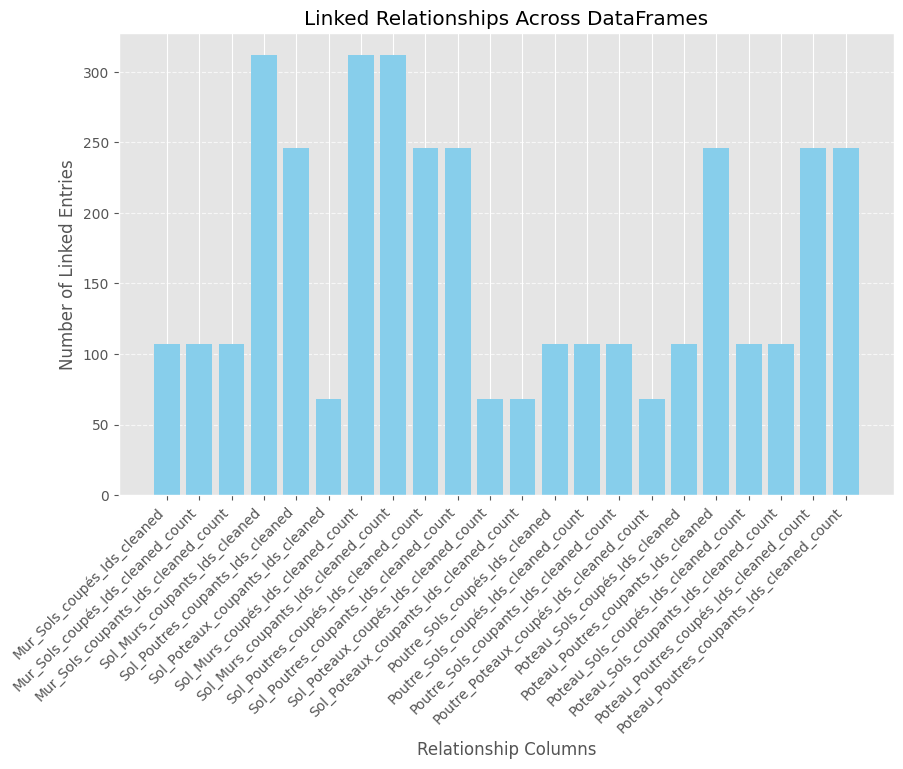

Interactive graph saved to ../../plot/linked_relationships.html


In [8]:
### ======================
### Link ID relationships
### ====================
from excel_link_id_relationships import link_id_relationships, plot_linked_relationships, plotly_network_graph
df_dict = {
    "Murs": murs_df,
    "Sols": sols_df,
    "Poutres": poutres_df,
    "Poteaux": poteaux_df
}
df_dict, linked_columns = link_id_relationships(df_dict)

### ====================================
### Visualize the linked relationships
### ====================================
plot_linked_relationships(df_dict, linked_columns)

### save the graph if not already saved
graph_path = os.path.join(plots_folder, "linked_relationships.png")
if not os.path.exists(graph_path):
    plt.savefig(graph_path, bbox_inches='tight')
    print(f"Graph saved to {graph_path}")


### Generate relationship graph
graph_links = plotly_network_graph(df_dict, linked_columns)
html_path = os.path.join(plots_folder, "linked_relationships.html")
graph_links.write_html(html_path)
print(f"Interactive graph saved to {html_path}")


In [9]:
import plotly.graph_objects as go
import networkx as nx

def plotly_graphs(df_dict, column_mapping):
    """
    Creates two interactive network graphs:
    - One for individual ID-based relationships (one node per connection).
    - One for quantity-based coupés and coupants relationships.

    Args:
        df_dict (dict): Dictionary containing DataFrames.
        column_mapping (dict): Mapping of sanitized column relationships.

    Returns:
        Tuple (fig_id_graph, fig_quantity_graph): Two Plotly figure objects.
    """
    G_ids = nx.Graph()  # Graph for ID-based relationships
    G_quantities = nx.Graph()  # Graph for coupés and coupants relationships

    # Build quantity-based graph for coupés/coupants relationships
    for main_df_name, df in df_dict.items():
        G_quantities.add_node(main_df_name, label=main_df_name, type='dataframe')

        for column in df.columns:
            if "_coupés_u" in column or "_coupants_u" in column:
                total_count = df[column].sum()
                if total_count > 0:  # Only add if there are actual relationships
                    # Extract the target object type from column name
                    parts = column.split('_')
                    target_type = parts[1] if len(parts) > 1 else "Unknown"
                    relation_type = "coupés" if "_coupés_u" in column else "coupants"

                    edge_label = f"{main_df_name} {relation_type} {target_type}: {total_count}"
                    G_quantities.add_edge(main_df_name, f"{target_type}s",
                                        label=edge_label, weight=total_count)

    # Build ID-based graph with individual connection nodes
    for main_df_name, df in df_dict.items():
        G_ids.add_node(main_df_name, label=main_df_name, type='dataframe')

        for column in df.columns:
            if "_coupés_Ids_cleaned" in column or "_coupants_Ids_cleaned" in column:
                # Extract target type and relation type
                parts = column.split('_')
                target_type = parts[1] if len(parts) > 1 else "Unknown"
                relation_type = "coupés" if "_coupés_Ids_cleaned" in column else "coupants"

                # Process each row to create individual connections
                for idx, row in df.iterrows():
                    ids_value = row[column]
                    if pd.notna(ids_value) and str(ids_value).strip():
                        # Split IDs and create individual connection nodes
                        ids_list = str(ids_value).split(',')
                        for individual_id in ids_list:
                            individual_id = individual_id.strip()
                            if individual_id:
                                # Create unique connection node - handle column name mapping
                                if main_df_name == 'Poteaux':
                                    id_column = 'Poteau_Id'
                                elif main_df_name == 'Poutres':
                                    id_column = 'Poutre_Id'
                                elif main_df_name == 'Murs':
                                    id_column = 'Mur_Id'
                                elif main_df_name == 'Sols':
                                    id_column = 'Sol_Id'
                                else:
                                    id_column = f'{main_df_name.rstrip("s")}_Id'
                                connection_node = f"{main_df_name}_{row[id_column]}_{relation_type}_{individual_id}"

                                G_ids.add_node(connection_node,
                                             label=f"{relation_type}\n{individual_id}",
                                             type='connection')

                                # Connect main dataframe to connection node
                                G_ids.add_edge(main_df_name, connection_node,
                                             label=f"{main_df_name}→{individual_id}")

                                # Connect connection node to target dataframe
                                target_df = f"{target_type}s"
                                if target_df in df_dict:
                                    G_ids.add_edge(connection_node, target_df,
                                                 label=f"{individual_id}→{target_df}")

    # Position nodes using different layouts
    pos_ids = nx.spring_layout(G_ids, seed=42, k=3, iterations=50)
    pos_quantities = nx.spring_layout(G_quantities, seed=42, k=2, iterations=50)

    def create_graph_trace(G, pos, title_suffix=""):
        """ Helper function to generate graph traces """
        edge_x, edge_y, edge_text = [], [], []

        for edge in G.edges():
            x0, y0 = pos[edge[0]]
            x1, y1 = pos[edge[1]]
            edge_x += [x0, x1, None]
            edge_y += [y0, y1, None]
            # Get edge data safely
            edge_data = G.edges[edge] if isinstance(G.edges[edge], dict) else {}
            edge_text.append(edge_data.get('label', ''))

        edge_trace = go.Scatter(x=edge_x, y=edge_y,
                               line=dict(width=1.5, color='#888'),
                               mode='lines', hoverinfo='none')

        node_x, node_y, node_text, node_color, node_size = [], [], [], [], []
        for node in G.nodes():
            x, y = pos[node]
            node_x.append(x)
            node_y.append(y)
            # Get node data safely
            node_data = G.nodes[node] if isinstance(G.nodes[node], dict) else {}
            node_type = node_data.get('type', 'default')

            node_type = G.nodes[node]['type']
            if node_type == 'dataframe':
                node_color.append('blue')
                node_size.append(25)
            elif node_type == 'connection':
                node_color.append('red')
                node_size.append(15)
            else:
                node_color.append('green')
                node_size.append(20)

        node_trace = go.Scatter(
            x=node_x, y=node_y,
            mode='markers+text',
            text=node_text,
            textposition="top center",
            hoverinfo='text',
            marker=dict(showscale=False, color=node_color, size=node_size, line_width=2)
        )
        return edge_trace, node_trace

    # Create ID-based graph
    edge_trace_ids, node_trace_ids = create_graph_trace(G_ids, pos_ids)
    fig_id_graph = go.Figure(data=[edge_trace_ids, node_trace_ids],
                             layout=go.Layout(
                                 title=dict(text='🔗 Individual ID Relationship Network', font=dict(size=16)),
                                 showlegend=False,
                                 hovermode='closest',
                                 margin=dict(b=20, l=5, r=5, t=40),
                                 xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                                 yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                             ))

    # Create Quantity-based graph
    edge_trace_quantities, node_trace_quantities = create_graph_trace(G_quantities, pos_quantities)
    fig_quantity_graph = go.Figure(data=[edge_trace_quantities, node_trace_quantities],
                                   layout=go.Layout(
                                       title=dict(text='📊 Quantity Relationship Network (coupés & coupants)', font=dict(size=16)),
                                       showlegend=False,
                                       hovermode='closest',
                                       margin=dict(b=20, l=5, r=5, t=40),
                                       xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                                       yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                                   ))

    return fig_id_graph, fig_quantity_graph


fig_id_graph, fig_quantity_graph = plotly_graphs(sanitized_data, relationships)
fig_id_graph.show()
fig_quantity_graph.show()

KeyError: 'type'

In [ ]:
###
### Show the network graph in a web browser
###
# import webbrowser
# webbrowser.open(os.path.join(plots_folder, "network_graph_quantities.html"))

# Feature Engineering & Target Preparation & Exploratory Data Analysis & Correlation Analysis


🔍 ANALYZING: MURS

📊 Missing Value Summary for Murs:


,Column,Missing Count,Missing %
Mur_Id,Mur_Id,0,0.00%
Mur_011EC_Lot,Mur_011EC_Lot,0,0.00%
Mur_012EC_Ouvrage,Mur_012EC_Ouvrage,0,0.00%
Mur_013EC_Localisation,Mur_013EC_Localisation,0,0.00%
Mur_014EC_Mode_Constructif,Mur_014EC_Mode_Constructif,0,0.00%
Mur_Hauteur,Mur_Hauteur,0,0.00%
Mur_Epaisseur,Mur_Epaisseur,0,0.00%
Mur_AI,Mur_AI,0,0.00%
Mur_AS,Mur_AS,0,0.00%
Mur_Sols_en_intersection,Mur_Sols_en_intersection,0,0.00%


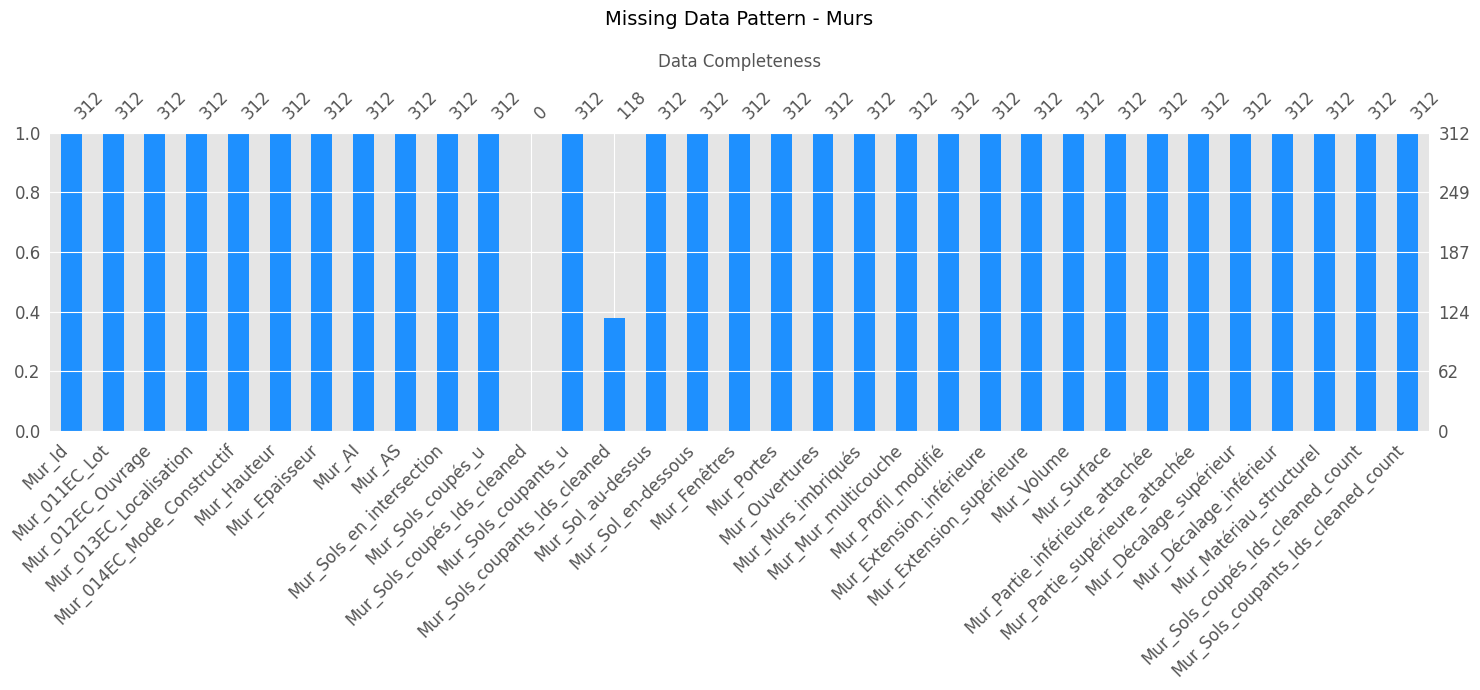


🔍 ANALYZING: SOLS

📊 Missing Value Summary for Sols:


,Column,Missing Count,Missing %
Sol_Id,Sol_Id,0,0.00%
Sol_011EC_Lot,Sol_011EC_Lot,0,0.00%
Sol_012EC_Ouvrage,Sol_012EC_Ouvrage,1,0.93%
Sol_013EC_Localisation,Sol_013EC_Localisation,4,3.74%
Sol_014EC_Mode_Constructif,Sol_014EC_Mode_Constructif,3,2.80%
Sol_Murs_en_intersection,Sol_Murs_en_intersection,0,0.00%
Sol_Murs_coupés_u,Sol_Murs_coupés_u,0,0.00%
Sol_Murs_coupés_Ids_cleaned,Sol_Murs_coupés_Ids_cleaned,46,42.99%
Sol_Murs_coupants_u,Sol_Murs_coupants_u,0,0.00%
Sol_Murs_coupants_Ids_cleaned,Sol_Murs_coupants_Ids_cleaned,107,100.00%


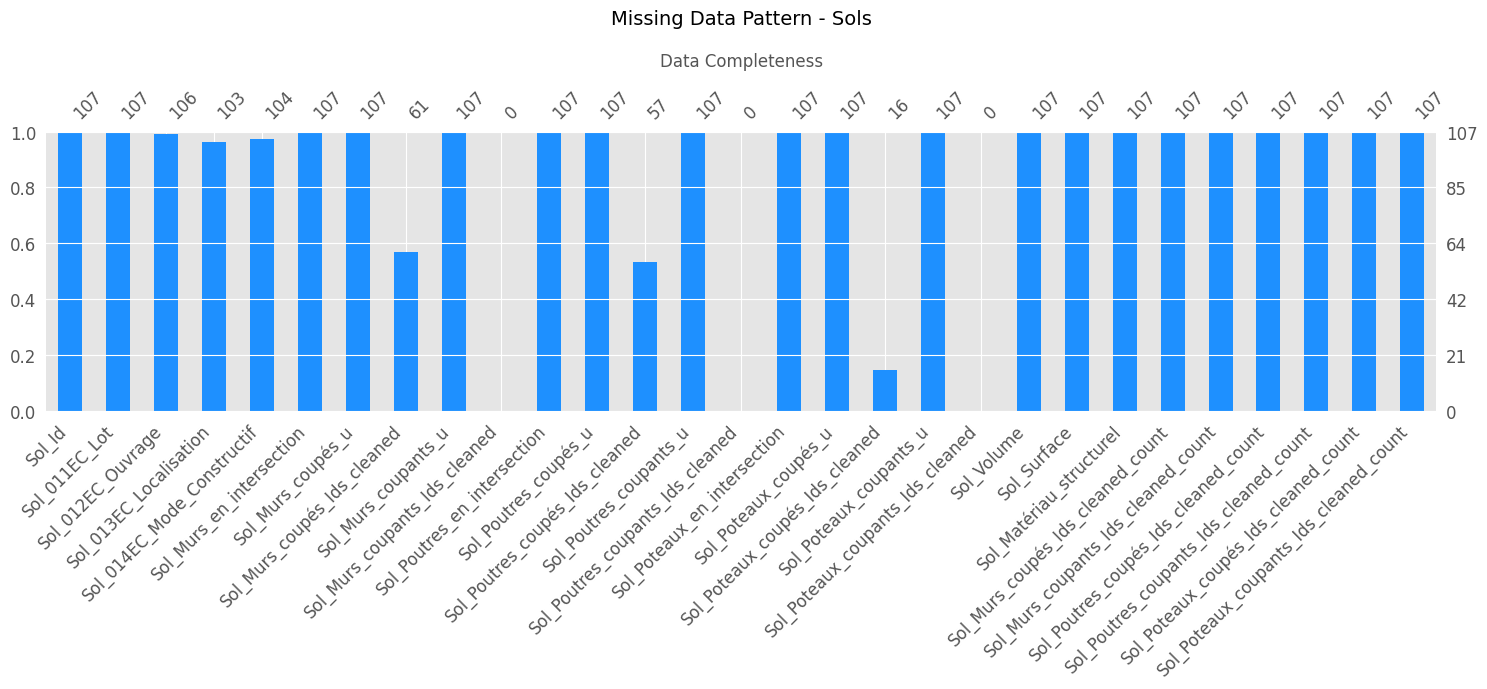


🔍 ANALYZING: POUTRES

📊 Missing Value Summary for Poutres:


,Column,Missing Count,Missing %
Poutre_Id,Poutre_Id,0,0.00%
Poutre_011EC_Lot,Poutre_011EC_Lot,4,1.63%
Poutre_012EC_Ouvrage,Poutre_012EC_Ouvrage,4,1.63%
Poutre_013EC_Localisation,Poutre_013EC_Localisation,4,1.63%
Poutre_014EC_Mode_Constructif,Poutre_014EC_Mode_Constructif,4,1.63%
Poutre_AI,Poutre_AI,0,0.00%
Poutre_AS,Poutre_AS,0,0.00%
Poutre_Hauteur_totale,Poutre_Hauteur_totale,0,0.00%
Poutre_Hauteur,Poutre_Hauteur,0,0.00%
Poutre_Sols_en_intersection,Poutre_Sols_en_intersection,0,0.00%


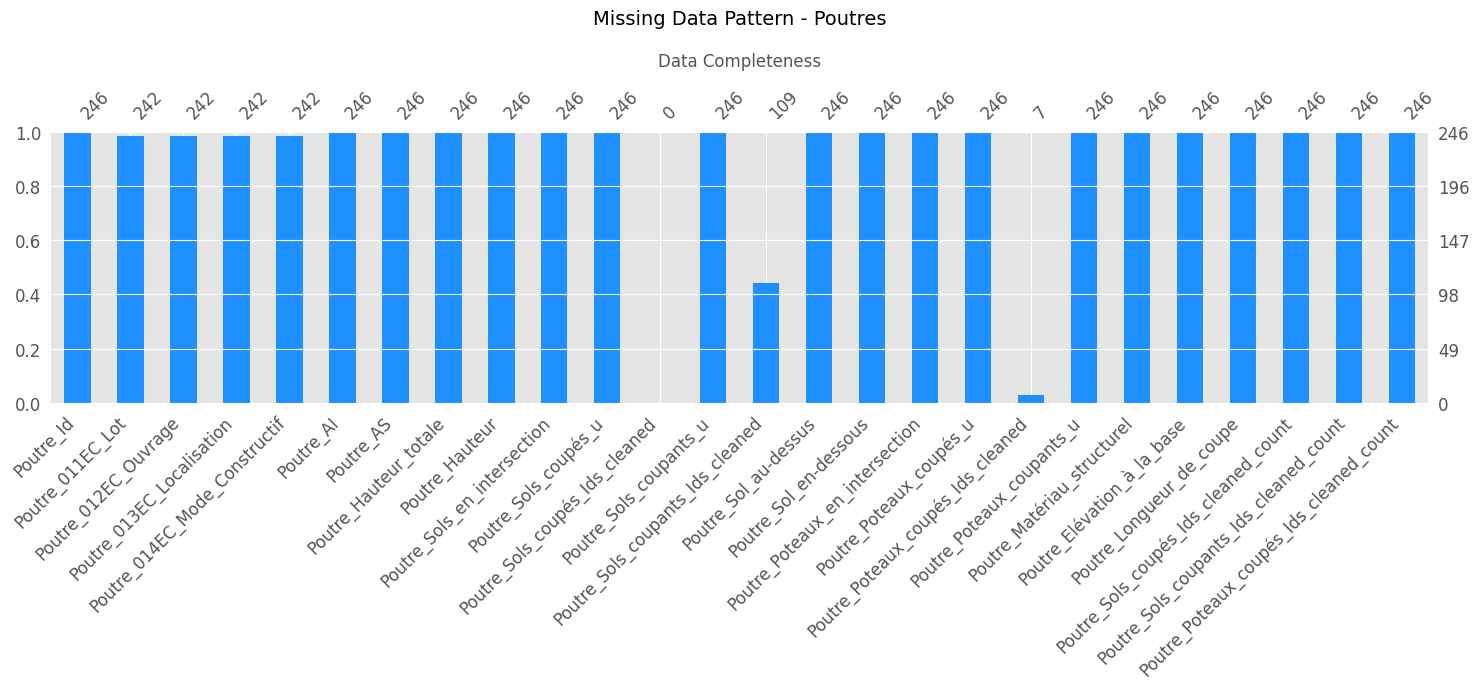


🔍 ANALYZING: POTEAUX

📊 Missing Value Summary for Poteaux:


,Column,Missing Count,Missing %
Poteau_Id,Poteau_Id,0,0.00%
Poteau_011EC_Lot,Poteau_011EC_Lot,0,0.00%
Poteau_012EC_Ouvrage,Poteau_012EC_Ouvrage,0,0.00%
Poteau_013EC_Localisation,Poteau_013EC_Localisation,0,0.00%
Poteau_014EC_Mode_Constructif,Poteau_014EC_Mode_Constructif,0,0.00%
Poteau_Nom,Poteau_Nom,0,0.00%
Poteau_AI,Poteau_AI,0,0.00%
Poteau_AS,Poteau_AS,0,0.00%
Poteau_Hauteur,Poteau_Hauteur,0,0.00%
Poteau_Longueur,Poteau_Longueur,0,0.00%


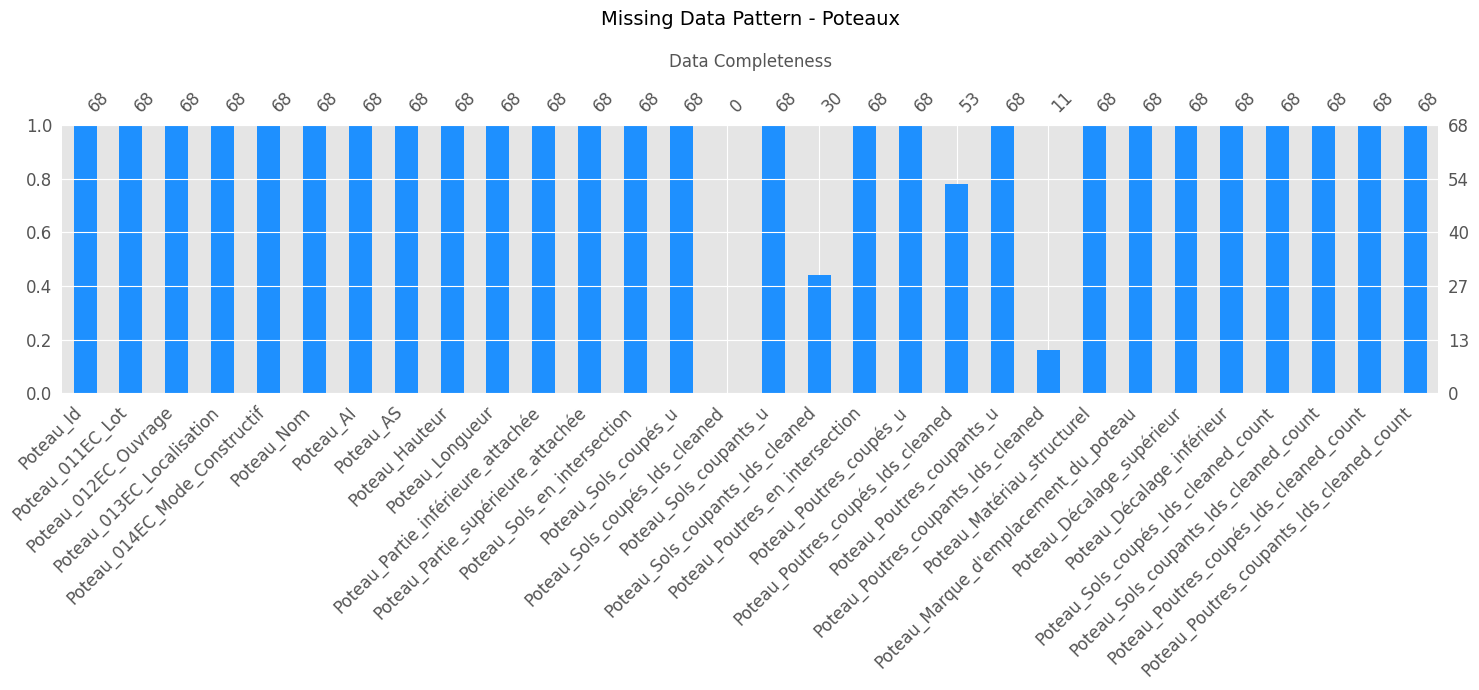

In [17]:
# Verify missing values in the DataFrames
from excel_verifiy_missing_values import verify_missing_values_with_missingno

missing_values = verify_missing_values_with_missingno(df_dict)


🔍 ANALYZING: MURS

❌ Dropped columns (100% missing):
 - Mur_Sols_coupés_Ids_cleaned

📊 Missing Value Summary for Murs:


,Column,Missing Count,Missing %
Mur_Id,Mur_Id,0,0.00%
Mur_011EC_Lot,Mur_011EC_Lot,0,0.00%
Mur_012EC_Ouvrage,Mur_012EC_Ouvrage,0,0.00%
Mur_013EC_Localisation,Mur_013EC_Localisation,0,0.00%
Mur_014EC_Mode_Constructif,Mur_014EC_Mode_Constructif,0,0.00%
Mur_Hauteur,Mur_Hauteur,0,0.00%
Mur_Epaisseur,Mur_Epaisseur,0,0.00%
Mur_AI,Mur_AI,0,0.00%
Mur_AS,Mur_AS,0,0.00%
Mur_Sols_en_intersection,Mur_Sols_en_intersection,0,0.00%


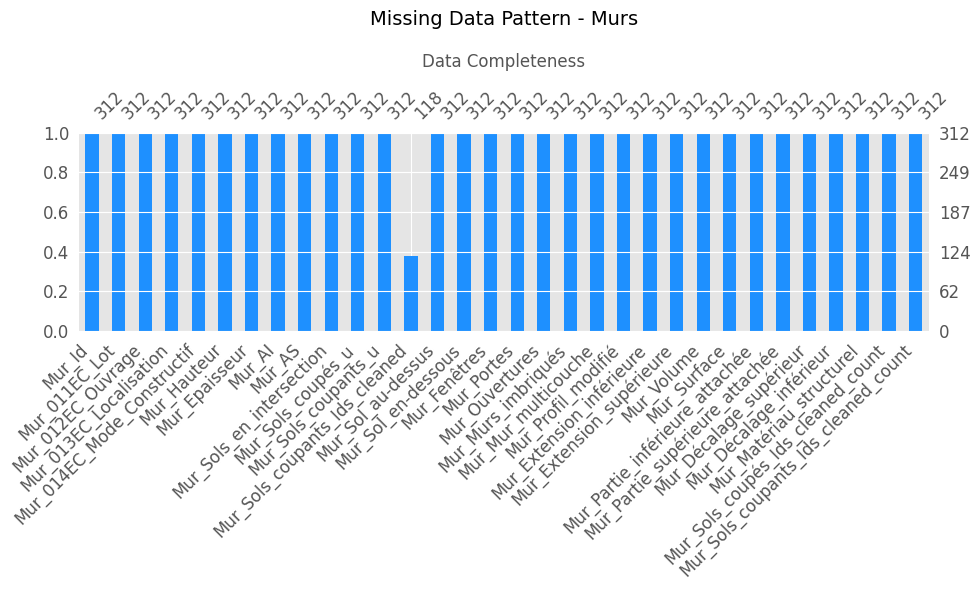


🔍 ANALYZING: SOLS

❌ Dropped columns (100% missing):
 - Sol_Murs_coupants_Ids_cleaned
 - Sol_Poutres_coupants_Ids_cleaned
 - Sol_Poteaux_coupants_Ids_cleaned

📊 Missing Value Summary for Sols:


,Column,Missing Count,Missing %
Sol_Id,Sol_Id,0,0.00%
Sol_011EC_Lot,Sol_011EC_Lot,0,0.00%
Sol_012EC_Ouvrage,Sol_012EC_Ouvrage,1,0.93%
Sol_013EC_Localisation,Sol_013EC_Localisation,4,3.74%
Sol_014EC_Mode_Constructif,Sol_014EC_Mode_Constructif,3,2.80%
Sol_Murs_en_intersection,Sol_Murs_en_intersection,0,0.00%
Sol_Murs_coupés_u,Sol_Murs_coupés_u,0,0.00%
Sol_Murs_coupés_Ids_cleaned,Sol_Murs_coupés_Ids_cleaned,46,42.99%
Sol_Murs_coupants_u,Sol_Murs_coupants_u,0,0.00%
Sol_Poutres_en_intersection,Sol_Poutres_en_intersection,0,0.00%


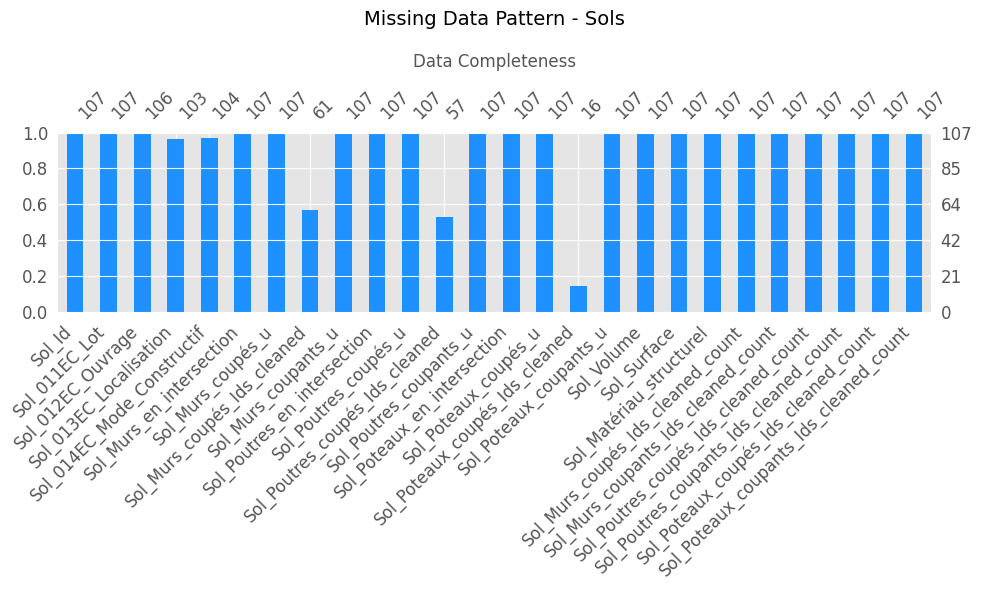


🔍 ANALYZING: POUTRES

❌ Dropped columns (100% missing):
 - Poutre_Sols_coupés_Ids_cleaned

📊 Missing Value Summary for Poutres:


,Column,Missing Count,Missing %
Poutre_Id,Poutre_Id,0,0.00%
Poutre_011EC_Lot,Poutre_011EC_Lot,4,1.63%
Poutre_012EC_Ouvrage,Poutre_012EC_Ouvrage,4,1.63%
Poutre_013EC_Localisation,Poutre_013EC_Localisation,4,1.63%
Poutre_014EC_Mode_Constructif,Poutre_014EC_Mode_Constructif,4,1.63%
Poutre_AI,Poutre_AI,0,0.00%
Poutre_AS,Poutre_AS,0,0.00%
Poutre_Hauteur_totale,Poutre_Hauteur_totale,0,0.00%
Poutre_Hauteur,Poutre_Hauteur,0,0.00%
Poutre_Sols_en_intersection,Poutre_Sols_en_intersection,0,0.00%


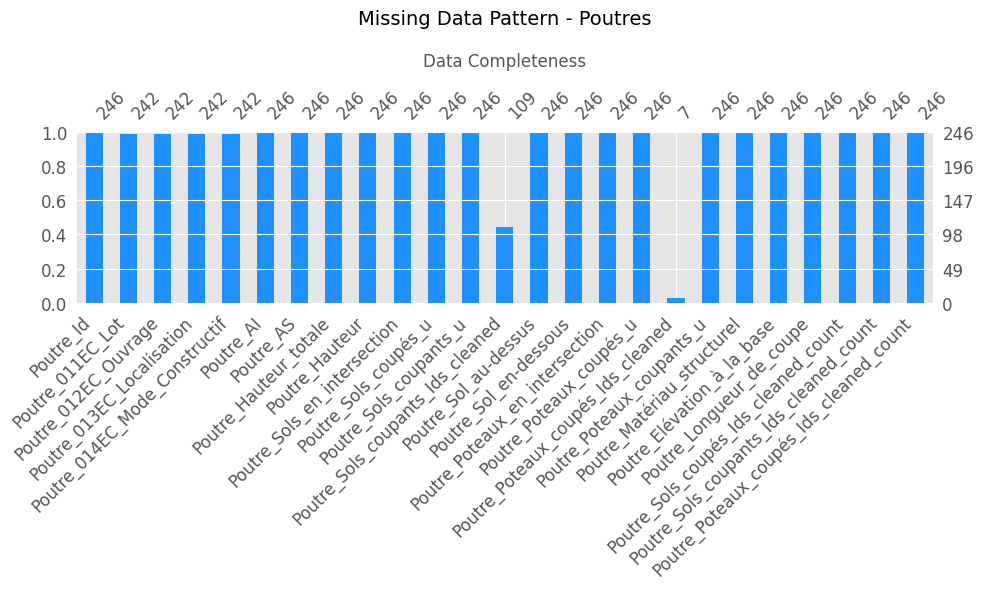


🔍 ANALYZING: POTEAUX

❌ Dropped columns (100% missing):
 - Poteau_Sols_coupés_Ids_cleaned

📊 Missing Value Summary for Poteaux:


,Column,Missing Count,Missing %
Poteau_Id,Poteau_Id,0,0.00%
Poteau_011EC_Lot,Poteau_011EC_Lot,0,0.00%
Poteau_012EC_Ouvrage,Poteau_012EC_Ouvrage,0,0.00%
Poteau_013EC_Localisation,Poteau_013EC_Localisation,0,0.00%
Poteau_014EC_Mode_Constructif,Poteau_014EC_Mode_Constructif,0,0.00%
Poteau_Nom,Poteau_Nom,0,0.00%
Poteau_AI,Poteau_AI,0,0.00%
Poteau_AS,Poteau_AS,0,0.00%
Poteau_Hauteur,Poteau_Hauteur,0,0.00%
Poteau_Longueur,Poteau_Longueur,0,0.00%


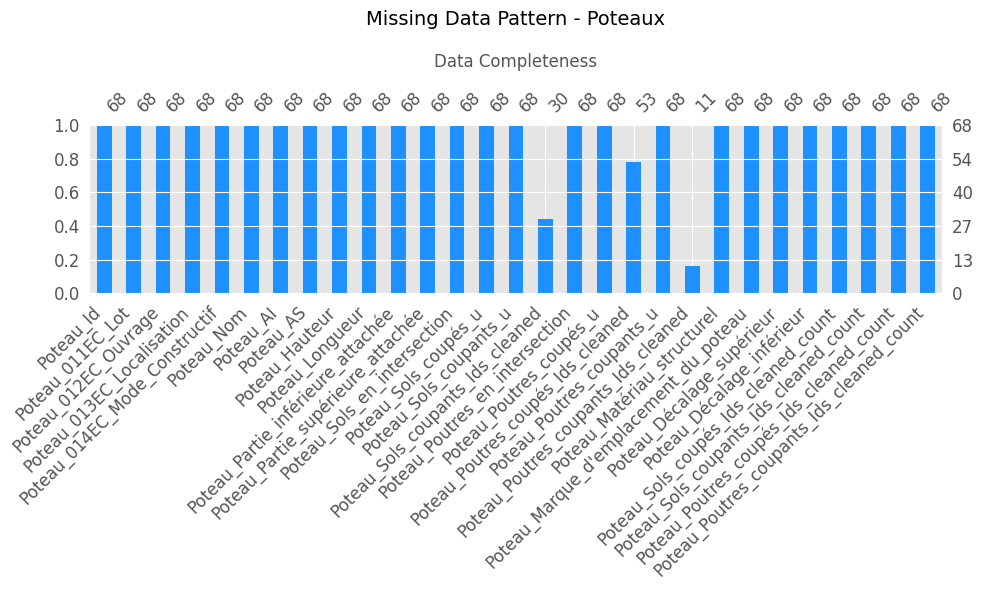


📋 SUMMARY OF DROPPED COLUMNS (100% missing)

Murs:
 - Mur_Sols_coupés_Ids_cleaned

Sols:
 - Sol_Murs_coupants_Ids_cleaned
 - Sol_Poutres_coupants_Ids_cleaned
 - Sol_Poteaux_coupants_Ids_cleaned

Poutres:
 - Poutre_Sols_coupés_Ids_cleaned

Poteaux:
 - Poteau_Sols_coupés_Ids_cleaned


In [ ]:
###
### Drop columns with 100% missing values
###

from excel_drop_zero_values import drop_zero_values_columns

updated_dfs, missing_results, dropped_cols = drop_zero_values_columns(df_dict)

# Print summary of dropped columns
print("\n" + "="*50)
print("📋 SUMMARY OF DROPPED COLUMNS (100% missing)")
print("="*50)
for df_name, cols in dropped_cols.items():
    if cols:  # Only show if columns were dropped
        print(f"\n{df_name}:")
        for col in cols:
            print(f" - {col}")

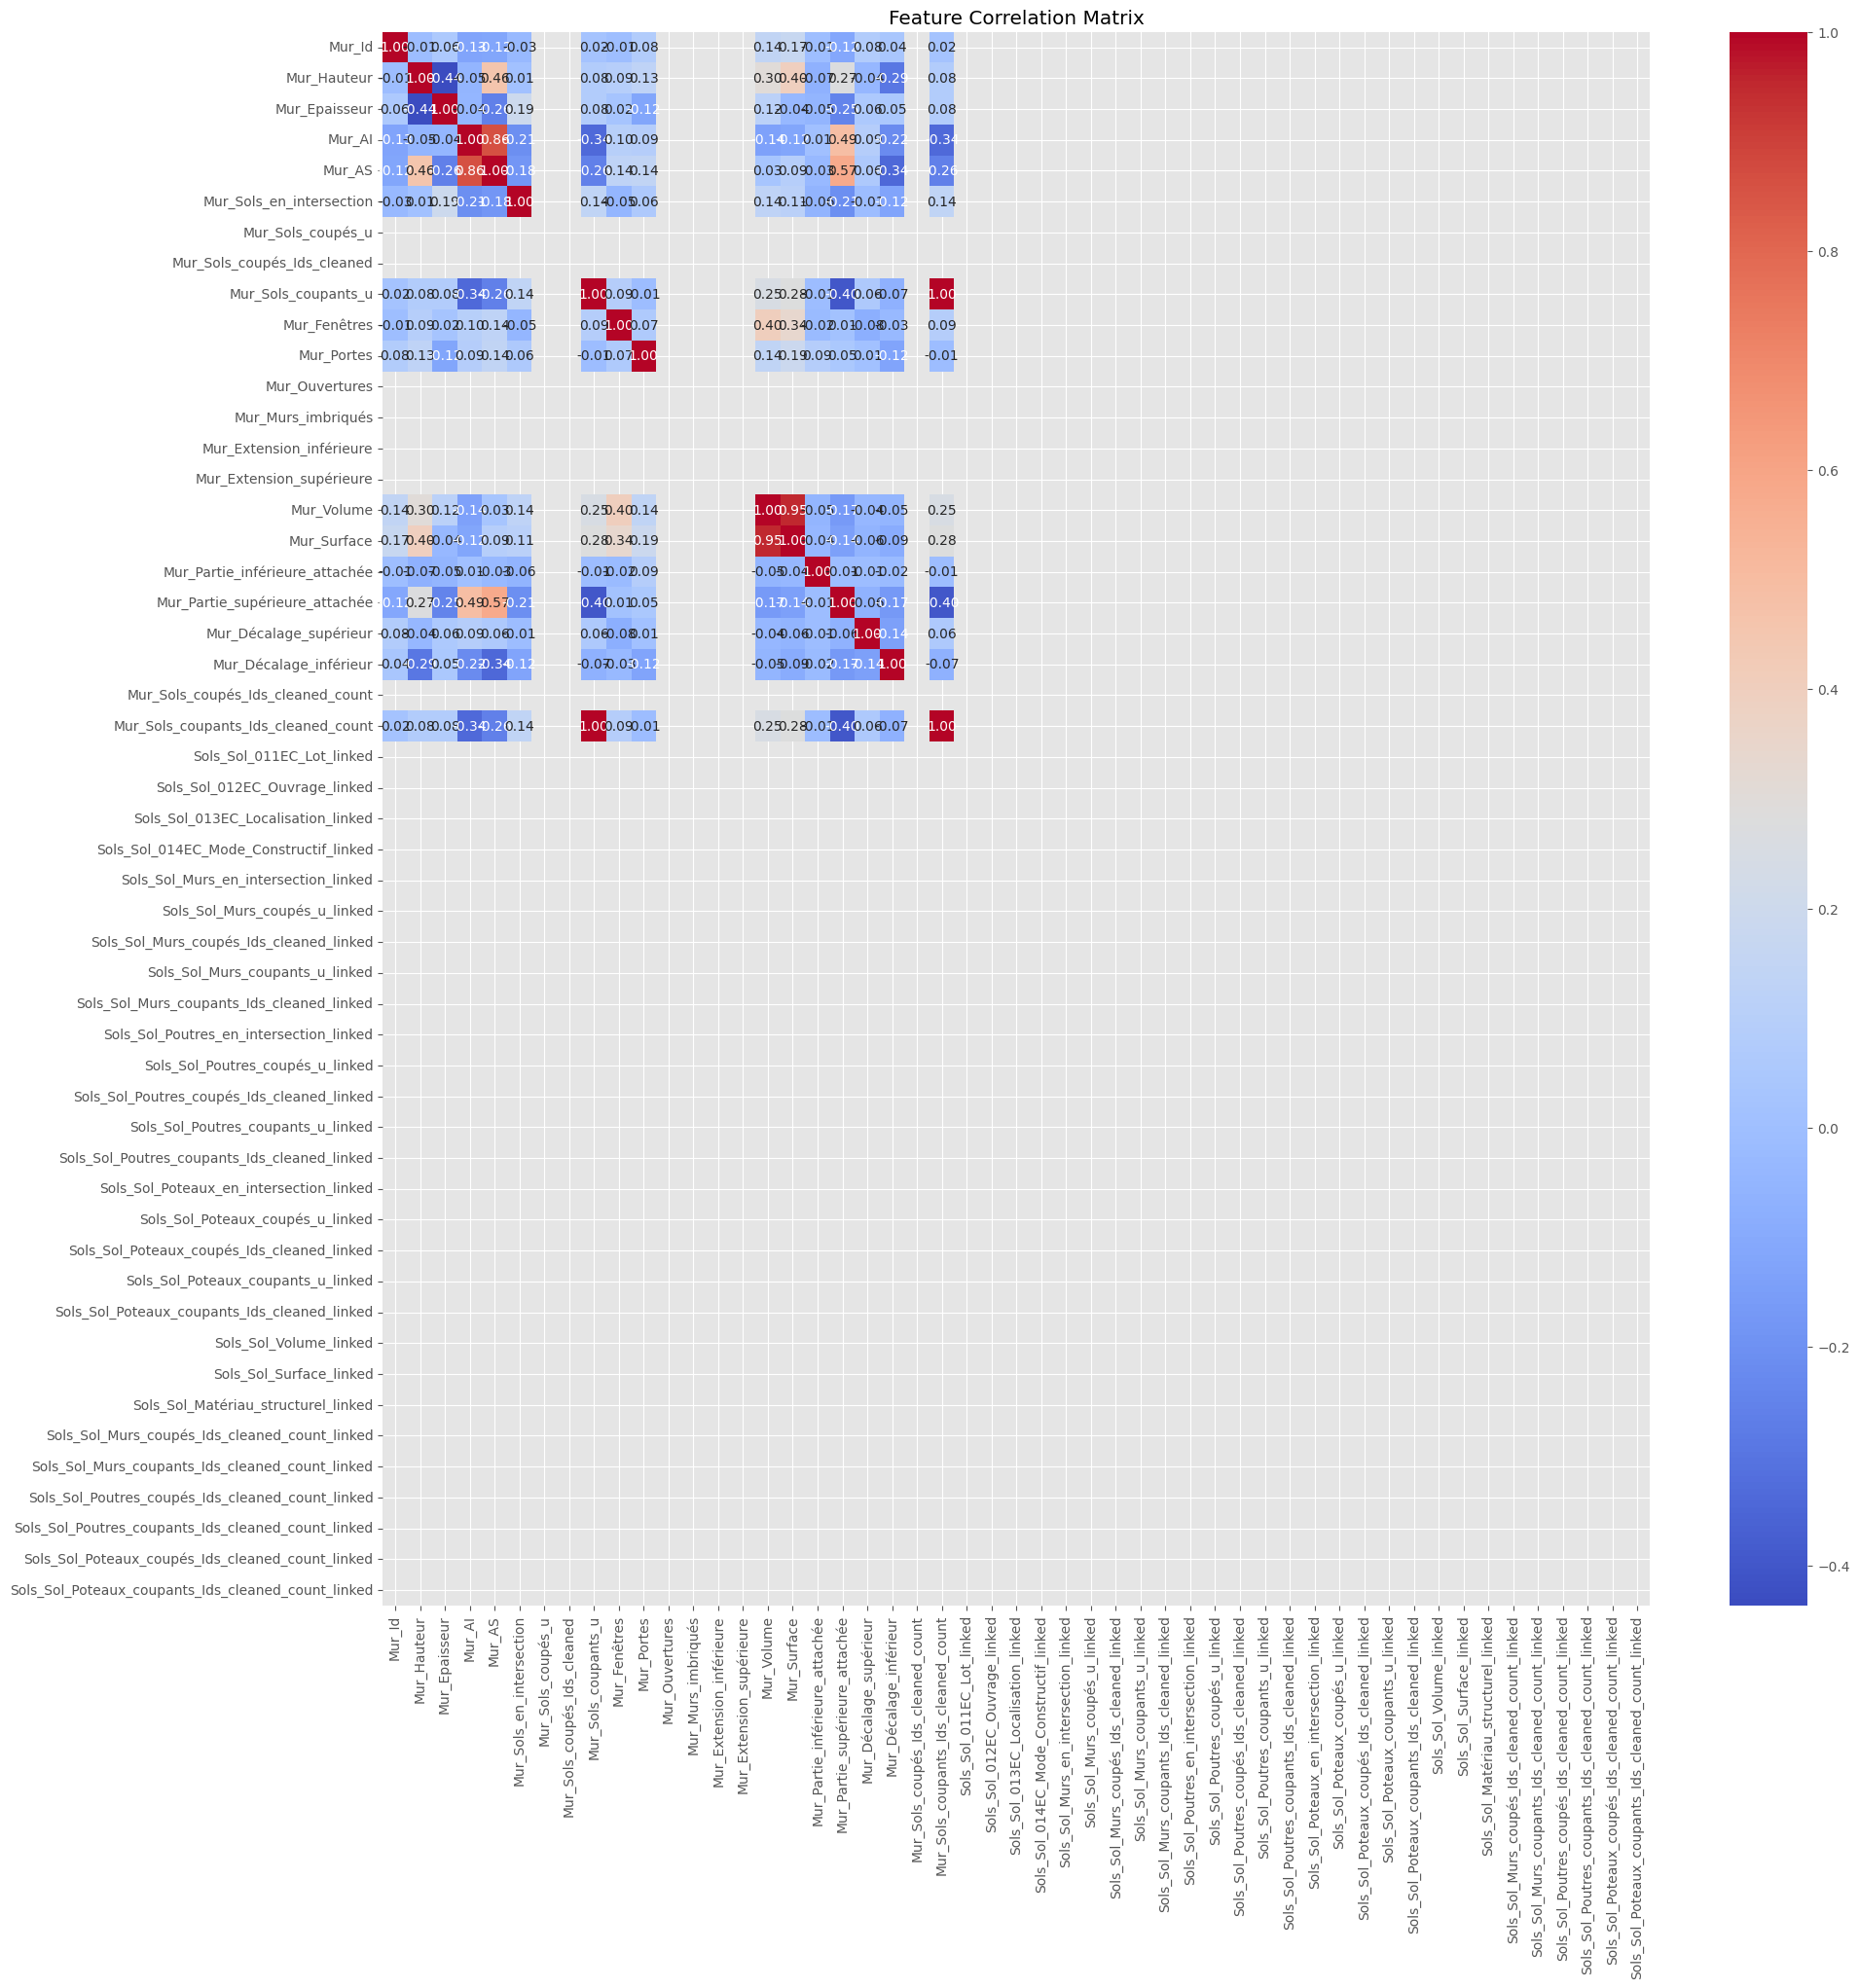

In [18]:
# Extract numerical columns for correlation mapping
corr_matrix = murs_df.select_dtypes(include=['number']).corr()

# Plot correlation heatmap
plt.figure(figsize=(21, 21))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

In [ ]:
# Feature selection for Murs DataFrame
# We'll exclude the target columns and ID columns from features
excluded_features = target_columns + ['Id', 'Sols coupés (Ids)', 'Sols coupants (Ids)']
features = [col for col in mur_df.columns if col not in excluded_features]

# Separate features and targets
X = mur_df[features]
y = mur_df[target_columns]

# Handle categorical features (text with special French characters)
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=np.number).columns

print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)

# Preprocessing pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Numeric transformer
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical transformer
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

# For multi-label classification, we'll use separate models for each target
# Or we can combine them into a single target (less recommended due to different natures)
# Here we'll proceed with separate models

# Get feature names after one-hot encoding
# For numeric features
numeric_feature_names = numeric_cols.tolist()

# For categorical features
if len(categorical_cols) > 0:
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    categorical_feature_names = ohe.get_feature_names_out(categorical_cols).tolist()
    all_feature_names = numeric_feature_names + categorical_feature_names
else:
    all_feature_names = numeric_feature_names

print(f"Total features after preprocessing: {len(all_feature_names)}")

In [ ]:
# Correlation analysis for each target variable
plt.figure(figsize=(15, 10))

# For numeric features only (correlation requires numeric data)
numeric_df = X[numeric_cols]

# Add targets to the numeric_df for correlation
for target in target_columns:
    if target in mur_df.columns:
        # Encode target for correlation
        le = LabelEncoder()
        encoded_target = le.fit_transform(mur_df[target])
        numeric_df[target] = encoded_target

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Plot heatmap for each target
for i, target in enumerate(target_columns, 1):
    if target in numeric_df.columns:
        plt.subplot(2, 2, i)
        target_corr = corr_matrix[target].sort_values(ascending=False)
        sns.barplot(x=target_corr.values[1:11], y=target_corr.index[1:11])
        plt.title(f'Top 10 Features Correlated with {target}')
        plt.tight_layout()

plt.show()

# Analyze distribution of target variables
plt.figure(figsize=(15, 10))
for i, target in enumerate(target_columns, 1):
    if target in mur_df.columns:
        plt.subplot(2, 2, i)
        sns.countplot(y=mur_df[target], order=mur_df[target].value_counts().index)
        plt.title(f'Distribution of {target}')
        plt.tight_layout()

plt.show()

# SHAP analysis for feature importance (sample for one target)
if '012EC_Ouvrage' in mur_df.columns:
    # Sample a subset for faster SHAP computation
    X_sample = X_processed[:1000] if X_processed.shape[0] > 1000 else X_processed

    # Train a model for this target
    y_target = mur_df['012EC_Ouvrage']
    le = LabelEncoder()
    y_encoded = le.fit_transform(y_target)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_sample, y_encoded, test_size=0.2, random_state=42)

    # Train a model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Compute SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # Plot summary
    plt.figure()
    shap.summary_plot(shap_values, X_test, feature_names=all_feature_names, class_names=le.classes_)
    plt.title('SHAP Summary for 012EC_Ouvrage Prediction')
    plt.show()

## Part 5: Model Training and Evaluation


In [ ]:
# Function to train and evaluate models for a target variable
def train_evaluate_models(X, y, target_name, models):
    """
    Train and evaluate multiple models for a target variable

    Args:
        X: Features (processed)
        y: Target variable
        target_name: Name of the target variable
        models: Dictionary of models to evaluate

    Returns:
        Dictionary of model performances
    """
    # Encode target if categorical
    if y.dtype == 'object':
        le = LabelEncoder()
        y = le.fit_transform(y)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42)

    results = {}

    for model_name, model in models.items():
        print(f"\nTraining {model_name} for {target_name}...")

        try:
            # Train model
            model.fit(X_train, y_train)

            # Predict
            y_pred = model.predict(X_test)

            # Evaluate
            accuracy = accuracy_score(y_test, y_pred)
            report = classification_report(y_test, y_pred, output_dict=True)

            # Store results
            results[model_name] = {
                'accuracy': accuracy,
                'precision': report['weighted avg']['precision'],
                'recall': report['weighted avg']['recall'],
                'f1': report['weighted avg']['f1-score']
            }

            print(f"{model_name} Accuracy: {accuracy:.4f}")

            # Save model based on type
            if hasattr(model, 'layers'):  # Keras model
                model_path = f"dlmodels/{target_name}_{model_name}.h5"
                model.save(model_path)
            elif 'boost' in model_name.lower() or 'forest' in model_name.lower():
                model_path = f"mlmodels/{target_name}_{model_name}.pkl"
                import joblib
                joblib.dump(model, model_path)
            else:
                model_path = f"simplemodels/{target_name}_{model_name}.pkl"
                import joblib
                joblib.dump(model, model_path)

        except Exception as e:
            print(f"Error with {model_name}: {e}")
            results[model_name] = None

    return results

# Define models to evaluate
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='rbf', probability=True, random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42),
}

# Add a simple neural network
def create_nn_model(input_dim, output_dim):
    model = Sequential([
        Dense(128, activation='relu', input_dim=input_dim),
        Dropout(0.2),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(optimizer=Adam(0.001),
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model

# For each target variable, train and evaluate models
all_results = {}

for target in target_columns:
    if target in mur_df.columns:
        print(f"\n{'='*50}")
        print(f"Training models for target: {target}")
        print(f"{'='*50}")

        y_target = mur_df[target]

        # Skip if all values are the same
        if len(y_target.unique()) == 1:
            print(f"Skipping {target} - only one class present.")
            continue

        # Add neural network to models
        output_dim = len(y_target.unique())
        nn_model = create_nn_model(X_processed.shape[1], output_dim)
        models['NeuralNetwork'] = nn_model

        # Train and evaluate
        results = train_evaluate_models(X_processed, y_target, target, models)
        all_results[target] = results

        # Remove NN for next target (to recreate with correct output dim)
        del models['NeuralNetwork']

        # Plot model comparison
        if results:
            df_results = pd.DataFrame(results).T
            df_results['accuracy'].plot(kind='bar', title=f'Model Accuracy for {target}')
            plt.ylabel('Accuracy')
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

# Display all results
for target, results in all_results.items():
    print(f"\nResults for {target}:")
    if results:
        display(pd.DataFrame(results).T)

## Part 6: Model Interpretation and Deployment

In [ ]:
# Function to interpret best model for each target
def interpret_best_model(target, results, X_processed, y_target):
    """
    Interpret the best model for a target using SHAP

    Args:
        target: Target variable name
        results: Dictionary of model results
        X_processed: Processed features
        y_target: Target values
    """
    if not results:
        return

    # Find best model by accuracy
    df_results = pd.DataFrame(results).T
    best_model_name = df_results['accuracy'].idxmax()
    best_model_accuracy = df_results.loc[best_model_name, 'accuracy']

    print(f"\nInterpreting best model for {target}: {best_model_name} (Accuracy: {best_model_accuracy:.4f})")

    # Load the best model
    if 'NeuralNetwork' in best_model_name:
        model_path = f"dlmodels/{target}_{best_model_name}.h5"
        best_model = tf.keras.models.load_model(model_path)

        # For neural networks, we'll use a different explainer
        # Sample data for faster computation
        X_sample = X_processed[:100] if X_processed.shape[0] > 100 else X_processed

        # Create a SHAP explainer
        explainer = shap.DeepExplainer(best_model, X_sample)
        shap_values = explainer.shap_values(X_sample)

        # Plot summary
        plt.figure()
        shap.summary_plot(shap_values, X_sample, feature_names=all_feature_names)
        plt.title(f'SHAP Summary for {target} ({best_model_name})')
        plt.show()

    else:
        if 'boost' in best_model_name.lower() or 'forest' in best_model_name.lower():
            model_path = f"mlmodels/{target}_{best_model_name}.pkl"
        else:
            model_path = f"simplemodels/{target}_{best_model_name}.pkl"

        import joblib
        best_model = joblib.load(model_path)

        # Create SHAP explainer
        X_sample = X_processed[:100] if X_processed.shape[0] > 100 else X_processed

        if hasattr(best_model, 'predict_proba'):
            explainer = shap.TreeExplainer(best_model)
            shap_values = explainer.shap_values(X_sample)

            # Plot summary
            plt.figure()
            shap.summary_plot(shap_values, X_sample, feature_names=all_feature_names)
            plt.title(f'SHAP Summary for {target} ({best_model_name})')
            plt.show()
        else:
            print(f"Cannot create SHAP explainer for {best_model_name}")

# Interpret best models for each target
for target, results in all_results.items():
    y_target = mur_df[target]
    interpret_best_model(target, results, X_processed, y_target)

# Final recommendations
print("\nFinal Recommendations:")
print("1. The best performing models have been saved in their respective folders (simplemodels/, mlmodels/, dlmodels/)")
print("2. SHAP analysis has been provided for model interpretability")
print("3. Consider feature engineering based on the correlation and SHAP analysis")
print("4. For deployment, use the best model for each target variable")
print("5. Monitor model performance over time as new data becomes available")

## Part 7: Learning Curves and Model Analysis

In [ ]:
# Function to plot learning curves
def plot_learning_curve(model, X, y, model_name, target_name):
    """
    Plot learning curves for a model

    Args:
        model: The model to evaluate
        X: Features
        y: Target
        model_name: Name of the model
        target_name: Name of the target variable
    """
    from sklearn.model_selection import learning_curve

    # If y is categorical, encode it
    if y.dtype == 'object':
        le = LabelEncoder()
        y = le.fit_transform(y)

    # Create CV training and test scores for various training set sizes
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=5, scoring='accuracy',
        train_sizes=np.linspace(0.1, 1.0, 5))

    # Calculate mean and standard deviation for training set scores
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    # Calculate mean and standard deviation for test set scores
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training score')
    plt.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-validation score')

    # Draw bands
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='green')

    # Create plot
    plt.title(f'Learning Curve for {model_name} ({target_name})')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy Score')
    plt.legend(loc='best')
    plt.grid()
    plt.show()

# Plot learning curves for best models
for target, results in all_results.items():
    if results:
        # Find best model by accuracy
        df_results = pd.DataFrame(results).T
        best_model_name = df_results['accuracy'].idxmax()

        # Load the best model
        if 'NeuralNetwork' in best_model_name:
            model_path = f"dlmodels/{target}_{best_model_name}.h5"
            best_model = tf.keras.models.load_model(model_path)
        elif 'boost' in best_model_name.lower() or 'forest' in best_model_name.lower():
            model_path = f"mlmodels/{target}_{best_model_name}.pkl"
            import joblib
            best_model = joblib.load(model_path)
        else:
            model_path = f"simplemodels/{target}_{best_model_name}.pkl"
            import joblib
            best_model = joblib.load(model_path)

        # Get target data
        y_target = mur_df[target]

        # Plot learning curve
        plot_learning_curve(best_model, X_processed, y_target, best_model_name, target)

Explanation and Next Steps
This comprehensive solution provides:

Data Loading and Preprocessing: Handles the complex relationships between different BIM elements (Murs, Sols, Poutres, Poteaux) and processes the French text data with special characters.

Feature Engineering: Creates relationship features between different BIM elements based on their intersections and cuts.

Exploratory Data Analysis: Includes correlation analysis and target distribution visualization.

Model Training: Evaluates multiple machine learning models (Logistic Regression, Random Forest, SVM, XGBoost, LightGBM) and a neural network for each target variable.

Model Interpretation: Uses SHAP values to explain model predictions and identify important features.

Model Saving: Saves the best models in appropriate folders based on their complexity (simplemodels/, mlmodels/, dlmodels/).

Learning Curves: Visualizes model performance with increasing training data size.

Next Steps:

Deploy the best models for each target variable in your BIM system.

Set up monitoring to track model performance over time.

Consider implementing an ensemble approach if prediction accuracy needs improvement.

Explore more sophisticated deep learning architectures if you have sufficient data.

Regularly update the models with new project data to maintain accuracy.

